In [2]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

In [3]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [4]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [5]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data.head()

(128800, 4)


,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,141.486033,99.346299
1,1,2 irrad @ 4 Gy,52.792768,99.346299
2,1,1 non irrad,96.082838,99.346299
3,1,2 irrad @ 4 Gy,100.306259,99.346299
4,1,1 non irrad,69.687151,99.346299


## Train/test split 

In [5]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])

In [6]:
# telo_test = telo_data.copy()

# y = telo_test[['4 C telo means']]
# X = telo_test.drop(['4 C telo means'], axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=X[['patient id', 
#                                                                                                    'timepoint']])

# train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
# test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [7]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [8]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [9]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## Random GridSearch for pipeline/model params

In [10]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [11]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [12]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [13]:
# bayesian optimized model
bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
                       objective ='reg:squarederror', random_state=0, subsample=.9,
                       gamma=1.7)

## Cross validation; MAE & R2 score 

In [14]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                          model=model, cv=5)

MAE per CV fold: 
[3.14493471 3.28649649 3.199954   3.26374708 3.24323016] 

MEAN of MAE all folds: 3.2276724873531735
STD of MAE all folds: 0.050234520978508466

MAE of predict_y_test & y_test: 3.1607166349558686
R2 between predict_y_test & y_test: 0.8882009723991472


In [15]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_xgb_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 99.30
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 104.71
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 96.64
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.47
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 123.25
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 100.89
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 104.21
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 105.10
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 97.52
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 104.79
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 80.58
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 94.54
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 9

Text(0.5, 1.0, 'Fig. 1')

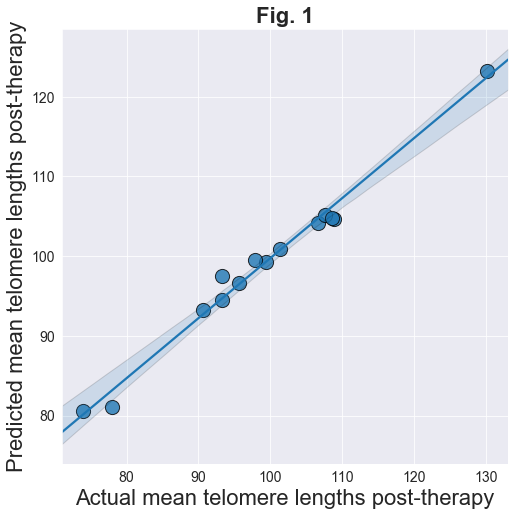

In [16]:
plt.figure(figsize=(8,8))
ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=22)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=22)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 1', fontsize=22, weight='bold')
# plt.savefig('predicting mean telos 3 months post.png')

In [18]:
# from xgboost import plot_tree

# plot_tree(fit_xgb_model)

## Looking directly at actual test 4 C telo means vs. predicted test 4 C telo means

In [19]:
test_clean_process_pipe = clean_process_pipe.set_params(cleaner__drop_patient_id=False)

test_run = test_set.copy()
test_run2 = test_clean_process_pipe.fit_transform(test_run)

In [20]:
test_run2_pred = fit_xgb_model.predict(test_run2[['individual telomeres', 'timepoint_1']])
df_test_run2_pred = pd.DataFrame({'4C telo PREDICTIONS': test_run2_pred})

viz = pd.concat([test_run2, df_test_run2_pred], axis=1)
viz.corr()

,patient id,individual telomeres,4 C telo means,timepoint_1,4C telo PREDICTIONS
patient id,1.000000,-0.234690,-5.083368e-01,0.000000e+00,-0.498493
individual telomeres,-0.234690,1.000000,2.180406e-01,1.053870e-01,0.274712
4 C telo means,-0.508337,0.218041,1.000000e+00,2.388334e-18,0.958097
timepoint_1,0.000000,0.105387,2.388334e-18,1.000000e+00,-0.002845
4C telo PREDICTIONS,-0.498493,0.274712,9.580972e-01,-2.845411e-03,1.000000


In [21]:
viz[viz['patient id'] == 5].groupby('patient id').agg('mean')

,individual telomeres,4 C telo means,timepoint_1,4C telo PREDICTIONS
patient id,,,,
5,99.17872,97.83219,0.5,99.471466


## Testing if model can predict 4C mean telomere length using *means

In [22]:
all_patients_4C = trp.combine_data(exploded_telos=exploded_telos_all_patients_df,
                                   all_patients_df=all_patients_df,
                                   prediction_objective='4 C means from telo means')

In [23]:
ML_mean_telos_pre = clean_process_pipe.set_params(cleaner__drop_patient_id=False).fit_transform(all_patients_4C)
ML_mean_telos_clean = ML_mean_telos_pre.copy()

# renaming telos means to enable compatability w/ model
ML_mean_telos_clean.rename(columns={'telo means':'individual telomeres'}, inplace=True)
# dropping to ensure only timepoint/ "individual telomeres" are seen by model
ML_mean_telos_clean.drop(['patient id', '4 C telo means'], axis=1, inplace=True)

In [24]:
pred_4C_telos = model.predict(ML_mean_telos_clean)
pred_4C_telos = pd.DataFrame({'y PREDICT 4C telos': pred_4C_telos})
alpha = pd.concat([ML_mean_telos_pre[['patient id', '4 C telo means']], pred_4C_telos], axis=1)[['patient id', '4 C telo means', 'y PREDICT 4C telos']]
alpha.corr()

,patient id,4 C telo means,y PREDICT 4C telos
patient id,1.000000,-0.508337,-0.274037
4 C telo means,-0.508337,1.000000,-0.053066
y PREDICT 4C telos,-0.274037,-0.053066,1.000000


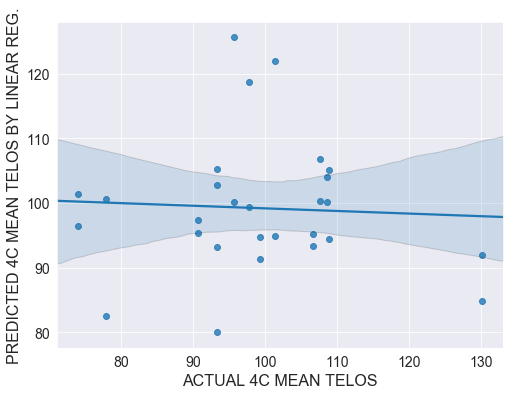

In [25]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=alpha['4 C telo means'], y=alpha['y PREDICT 4C telos'])
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

## Testing if linear regression can predict 4C mean telos using individual telos

In [37]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [38]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                         model=lr_model, cv=5)

MAE per CV fold: 
[9.46801952 9.55114047 9.47407975 9.53023389 9.56723487] 

MEAN of MAE all folds: 9.518141699641268
STD of MAE all folds: 0.04024665939273741

MAE of predict_y_test & y_test: 9.502749440878175
R2 between predict_y_test & y_test: 0.048014527622958325


In [39]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe)

patient 1: ACTUAL 4 C telo means: 99.35 --- PREDICTED 4 C telo means: 98.38
patient 2: ACTUAL 4 C telo means: 108.92 --- PREDICTED 4 C telo means: 101.32
patient 3: ACTUAL 4 C telo means: 95.67 --- PREDICTED 4 C telo means: 98.13
patient 5: ACTUAL 4 C telo means: 97.83 --- PREDICTED 4 C telo means: 99.26
patient 6: ACTUAL 4 C telo means: 130.12 --- PREDICTED 4 C telo means: 98.17
patient 7: ACTUAL 4 C telo means: 101.40 --- PREDICTED 4 C telo means: 99.99
patient 8: ACTUAL 4 C telo means: 106.65 --- PREDICTED 4 C telo means: 100.27
patient 9: ACTUAL 4 C telo means: 107.67 --- PREDICTED 4 C telo means: 99.04
patient 10: ACTUAL 4 C telo means: 93.35 --- PREDICTED 4 C telo means: 101.07
patient 11: ACTUAL 4 C telo means: 108.57 --- PREDICTED 4 C telo means: 100.61
patient 12: ACTUAL 4 C telo means: 73.99 --- PREDICTED 4 C telo means: 98.25
patient 14: ACTUAL 4 C telo means: 93.28 --- PREDICTED 4 C telo means: 97.23
patient 15: ACTUAL 4 C telo means: 90.68 --- PREDICTED 4 C telo means: 97.

In [28]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=y_lr_predict)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

NameError: name 'y_true' is not defined

<Figure size 576x432 with 0 Axes>

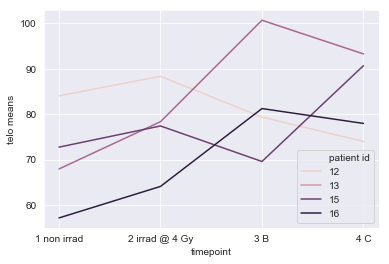

In [29]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[all_patients_df['patient id'].isin([12, 14, 15, 16])])

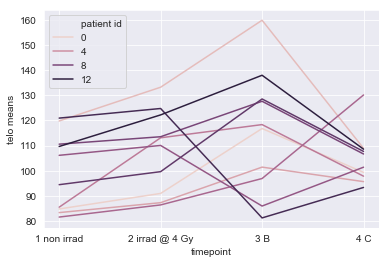

In [30]:
sns.lineplot(x='timepoint', y='telo means', hue='patient id', data=all_patients_df[~all_patients_df['patient id'].isin([12, 13, 14, 15, 16])])

In [31]:
training_MAE = []
test_MAE = []
max_depth_XGB = [3, 4, 5, 10, 15, 20, 25]

X = train_clean[['timepoint_1', 'individual telomeres']]
y = train_clean['4 C telo means']

X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=0)

X_test = test_clean[['timepoint_1', 'individual telomeres']]
y_test = test_clean['4 C telo means']

for param in max_depth_XGB:
    model = XGBRegressor(max_depth=param, learning_rate=0.1, n_estimators=100, objective='reg:squarederror')
    model.fit(X_train, y_train)
    
    predict_y_val = model.predict(X_val)
    training_MAE.append(mean_absolute_error(predict_y_val, y_val))
    
    predict_y_test = model.predict(X_test)
    test_MAE.append(mean_absolute_error(predict_y_test, y_test))

In [32]:
viz_traintest_MAE = pd.DataFrame({'training_MAE': training_MAE,
                                  'test_MAE': test_MAE,
                                  'max_depth_XGB': max_depth_XGB})

In [33]:
viz_traintest_MAE = viz_traintest_MAE.melt(id_vars='max_depth_XGB',
                                           value_vars=['training_MAE', 'test_MAE'],
                                           var_name='data type',
                                           value_name='MAE'
                                           )

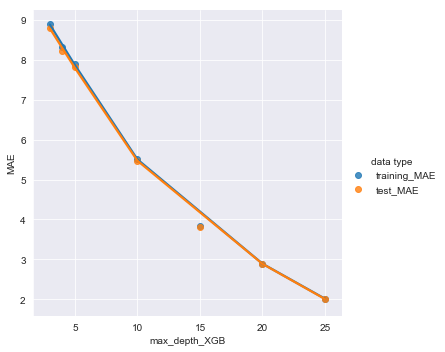

In [34]:
sns.lmplot(x='max_depth_XGB', y='MAE', data=viz_traintest_MAE, hue='data type', lowess=True)

## Visualization

In [ ]:
# visualize hyperparameters of XGBoost vs model accuracy
# visualize training vs. test MAE w/ changes params
# visualize fit 

In [ ]:
test2 = pd.DataFrame({'predict_y_test': predict_y_test, 'y_test': y_test}).reset_index(drop=True)
test2['residuals'] = test2['predict_y_test'] - test2['y_test']
test2.head()

In [ ]:
sns.lmplot(x='predict_y_test', y='y_test', data=test2)

In [ ]:
sns.lmplot(x='predict_y_test', y='residuals', data=test2)

In [ ]:
from statsmodels.graphics.gofplots import qqplot
qqplot(test2['residuals'])

In [ ]:
sns.jointplot(x='predict_y_test', y='y_test', kind='kde', data=test2)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [ ]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [ ]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')

quartile_telo_data.head()

## Train/test split 

In [ ]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [ ]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [ ]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0,)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', clean_process_pipe),
                        ('model', model)
                       ])

## Cleaning/modeling data with pipeline

In [ ]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [ ]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                            model=q_model, cv=5, 
                                            target='4 C # short telos')

In [ ]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe)

In [ ]:
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
# ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
# ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
# ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')

plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [66]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [68]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

In [44]:
chr_test.shape

(252, 10)

## Initializing cleaning/model pipelines

In [45]:
features = ['# inversions', 
            '# terminal inversions', 
            '# dicentrics', 
            '# translocations'
           ]

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=False, 
                                                                             bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target='aberration index',
                                                                                 features=features))
                                    ])

In [46]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,
                        )

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                      ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [47]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

## Bayesian Optimization

In [48]:
target = '4 C aberration index'
features = [col for col in cleaned_chr_train if col != target and col != 'patient id']

X_train = cleaned_chr_train[features].copy()
y_train = cleaned_chr_train[target].copy()

In [ ]:
def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
                        subsample, colsample, gamma):
 
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
 
    clf = XGBRegressor(max_depth=max_depth,
                       learning_rate=learning_rate,
                       n_estimators=n_estimators,
                       gamma=gamma, objective='reg:tweedie',)
    
    return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))

pbounds = {
    'learning_rate': (0.1, 0.3),
    'n_estimators': (100, 200),
    'max_depth': (3, 30),
    'subsample': (1.0, 1.0),  # Change for big datasets
    'colsample': (0.8, 1.0),  # Change for datasets with lots of features
    'gamma': (0, 3),
    }
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=5, n_iter=3)

## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [50]:
bo_model = XGBRegressor(n_estimators=100, 
                        max_depth=3, 
                        learning_rate=0.29,
                        objective='reg:squarederror',
                        colsample=.8897,
                        gamma=3.185,
                        random_state=0,
                        )

In [51]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

chr_fit_xgb_model = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=bo_model, cv=5, 
                                              target='4 C aberration index',)

MAE per CV fold: 
[0.43111945 0.13587838 0.2732644  0.2255515  0.09837438] 

MEAN of MAE all folds: 0.2328376214025823
STD of MAE all folds: 0.11703380114248628

MAE of predict_y_test & y_test: 0.3337599947339013
R2 between predict_y_test & y_test: -0.2733305564952144


In [ ]:
cleaned_chr_test.head()

In [ ]:
target = '4 C aberration index'
features = [col for col in cleaned_chr_test if col != target and col != 'patient id']
features
# predicts = chr_fit_xgb_model.predict(cleaned_chr_test[features])
# combined = pd.concat([cleaned_chr_test.reset_index(), pd.DataFrame({'predictions':predicts})], axis=1)
# predicts

In [ ]:
# testing = chr_fit_xgb_model.predict(chr_train_set[['# inversions', 'timepoint_2 irrad @ 4 Gy']])
# pd.DataFrame(testing)

In [ ]:
# q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
#                                                                  model=q_fit_xgb_model, target='4 C # short telos',
#                                                                  clean_process_pipe=q_clean_process_pipe)

In [ ]:
# plt.figure(figsize=(8,6))
# ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict)
# ax.set_xlabel('ACTUAL 4C # SHORT TELOS', fontsize=16)
# ax.set_ylabel('PREDICTED 4C # SHORT TELOS BY XGB MODEL', fontsize=16)
# ax.tick_params(labelsize=14)
# plt.savefig('predicting # short telos 3 months post.png')

plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

# Clustering telomere data

## Mean telomere length (teloFISH)

In [3]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'Q1'], axis=1)

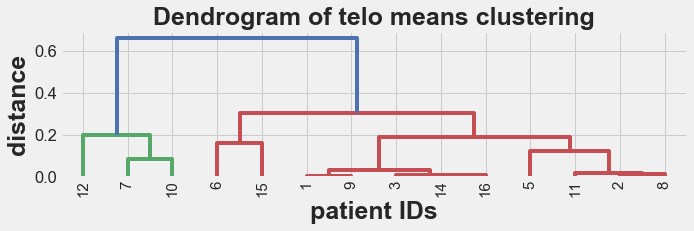

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


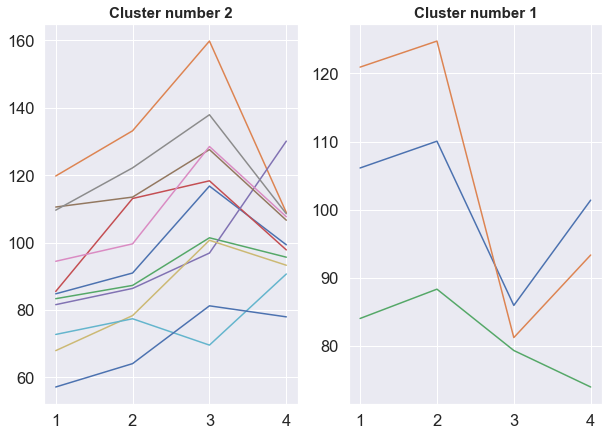

In [54]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             y_size=7)

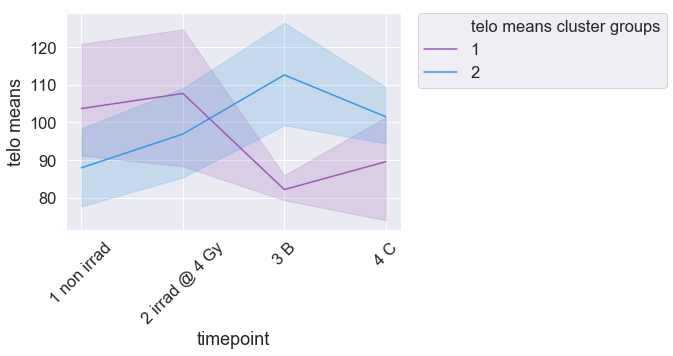

In [55]:
trp.graph_cluster_groups(clustered_telos, target='telo means', hue='telo means cluster groups')

telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


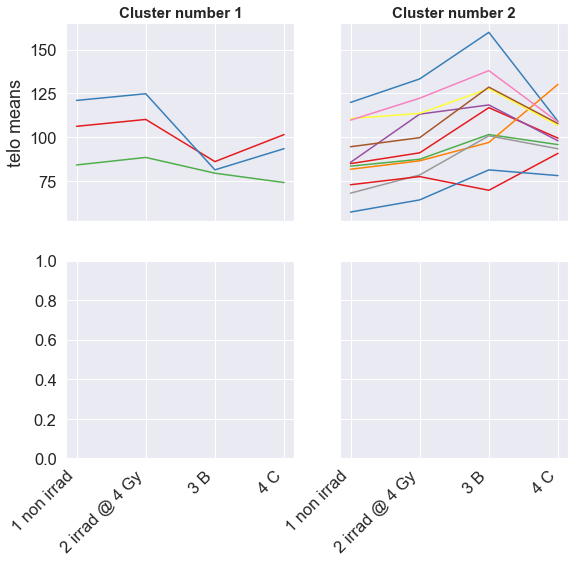

In [65]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means')

## Short telomeres

In [60]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': '# short telomeres'}, inplace=True)

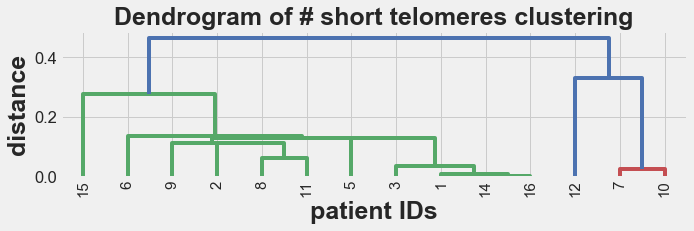

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


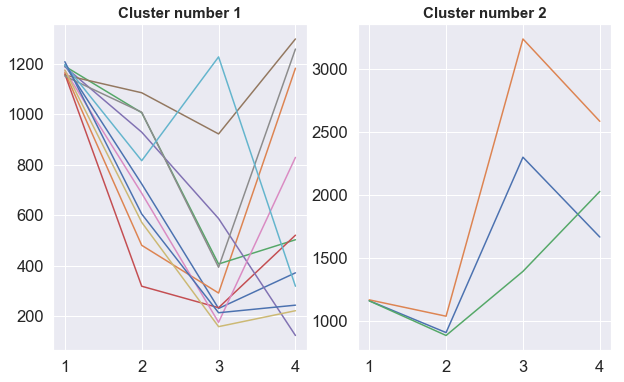

In [61]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='# short telomeres', cut_off_n=2)

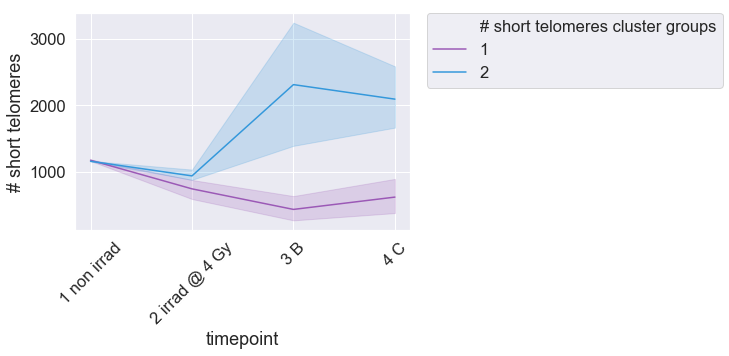

In [62]:
trp.graph_cluster_groups(clustered_short_telos, target='# short telomeres', hue='# short telomeres cluster groups')

# short telomeres CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 16]
# short telomeres CLUSTER 2 | patient IDs: [15]
# short telomeres CLUSTER 3 | patient IDs: [7, 10]
# short telomeres CLUSTER 4 | patient IDs: [12]


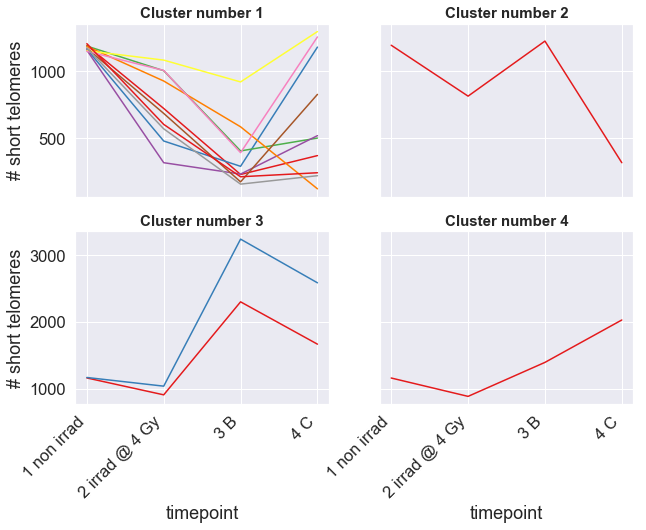

In [26]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=2, x_dimen=2, fsize=(10, 7))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

In [27]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Mean telomere length (qPCR)

In [63]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

,patient id,timepoint,telo means qPCR
0,1,1,2.182028
1,1,3,1.964348
2,1,4,1.749799
3,2,1,1.669445
4,2,3,1.780092


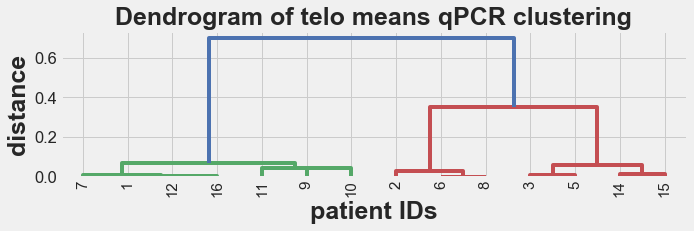

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


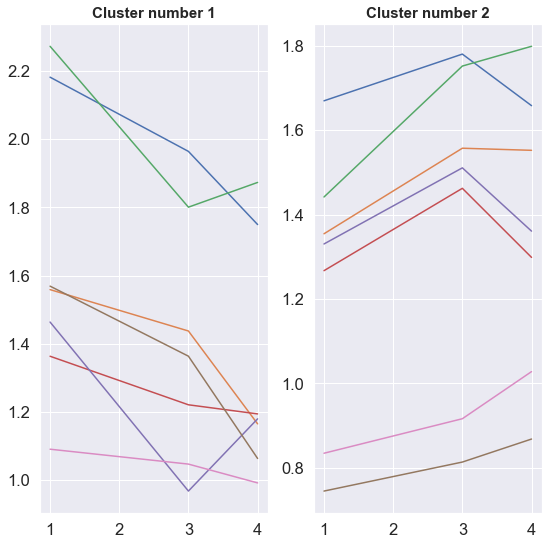

In [64]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

# Clustering chromosome rearrangement data

In [69]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

## Inversions

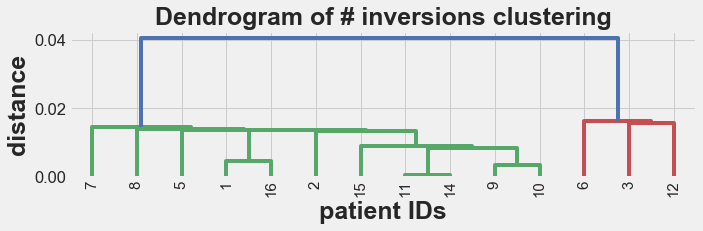

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


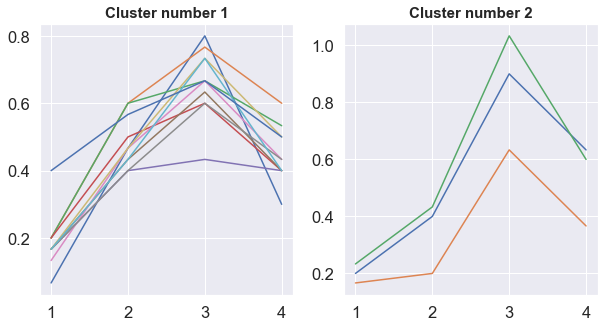

In [70]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

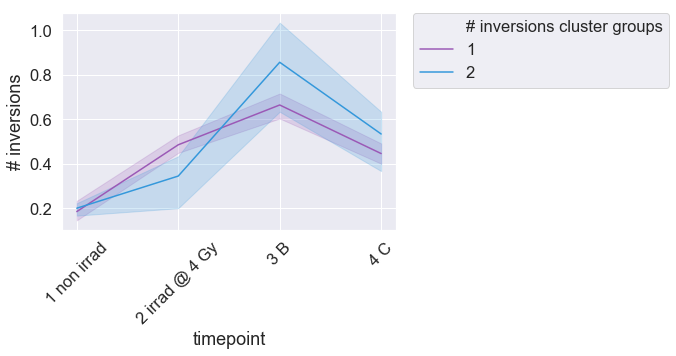

In [71]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 2, 5, 7, 8, 9, 10, 11, 14, 15, 16]
# inversions CLUSTER 2 | patient IDs: [3, 6, 12]


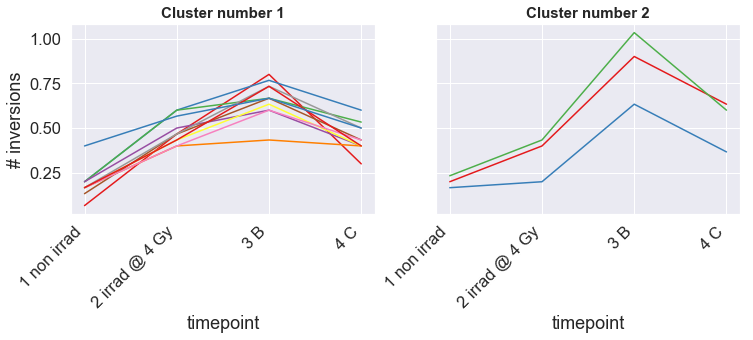

In [72]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

In [73]:
clustered_invs[clustered_invs['patient id'] == 12]

,patient id,# inversions cluster groups,timepoint,# inversions
10,12,2,1 non irrad,0.233333
24,12,2,2 irrad @ 4 Gy,0.433333
38,12,2,3 B,1.033333
52,12,2,4 C,0.600000


In [14]:
compare_clusters = clustered_telos.merge(clustered_invs, on=['patient id', 'timepoint'])
compare_clusters.corr()

,patient id,telo means cluster groups,telo means,# inversions cluster groups,# inversions
patient id,1.000000,-0.154811,-0.462786,-0.169364,0.022364
telo means cluster groups,-0.154811,1.000000,0.101766,-0.135978,0.016971
telo means,-0.462786,0.101766,1.000000,-0.209191,0.128929
# inversions cluster groups,-0.169364,-0.135978,-0.209191,1.000000,0.075477
# inversions,0.022364,0.016971,0.128929,0.075477,1.000000


## Dicentrics

In [31]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_dicent = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

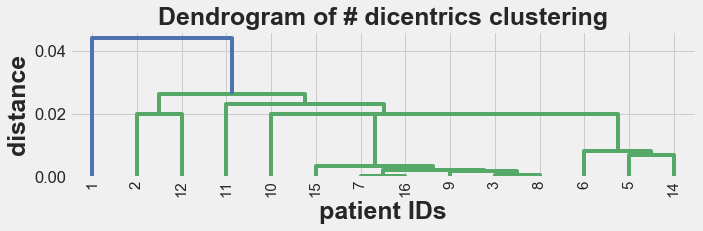

0 Cluster number 3 has 1 elements
1 Cluster number 1 has 2 elements
2 Cluster number 2 has 11 elements


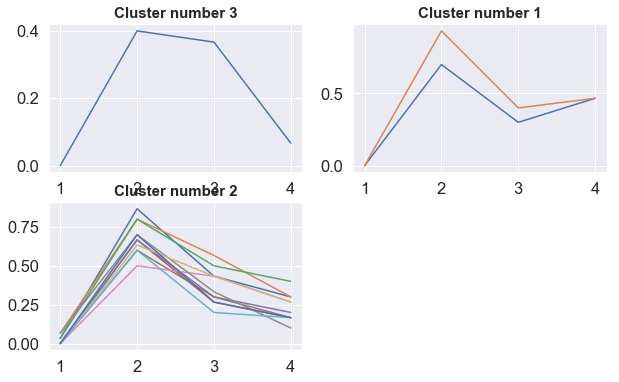

In [32]:
clustered_dicent = trp.cluster_data_return_df(mean_dicent, target='# dicentrics', cut_off_n=3)

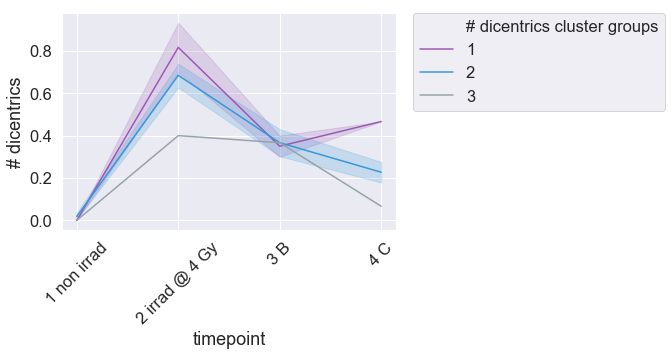

In [33]:
trp.graph_cluster_groups(clustered_dicent, target='# dicentrics', hue='# dicentrics cluster groups')

# dicentrics CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


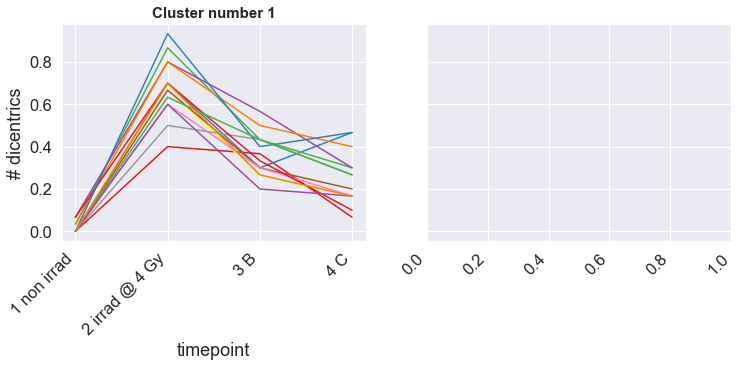

In [18]:
trp.graph_clusters_per_patient(clustered_dicent, target='# dicentrics', 
                               y_dimen=1, x_dimen=2, fsize=(12,4))

In [ ]:
# chr_aberr = [col for col in mean_chr.columns if col != 'patient id' and col != 'timepoint']

# for target in chr_aberr:
#     clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=4)
#     trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
#     trp.graph_clusters_per_patient(clustered, target=target,
#                                    y_dimen=2, x_dimen=2,
#                                    fsize=(12,3.5))

# Clustering telomeres + chromosome rearrangement data

In [77]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)

combined_data = means_qPCR.merge(mean_chr, on=['patient id', 'timepoint'])
combined_data.head()

,patient id,timepoint,telo means qPCR,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations
0,1,1 non irrad,2.182028,0.066667,0.166667,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333
1,1,3 B,1.964348,0.800000,0.466667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000
2,1,4 C,1.749799,0.300000,0.266667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333
3,2,1 non irrad,1.669445,0.200000,0.100000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333
4,2,3 B,1.780092,0.766667,0.300000,0.700000,0.300000,0.166667,0.466667,1.000000,0.033333


In [78]:
combined_data.corr()

,patient id,telo means qPCR,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations
patient id,1.000000,-0.727371,0.028363,0.098589,-0.663084,-0.116706,-0.120282,-0.262275,0.290432,-0.103807
telo means qPCR,-0.727371,1.000000,-0.070538,-0.149533,0.567774,-0.016668,0.048083,0.007022,-0.328996,-0.077618
# inversions,0.028363,-0.070538,1.000000,0.507592,0.039416,0.833096,0.720784,0.630637,-0.192776,0.547644
# terminal inversions,0.098589,-0.149533,0.507592,1.000000,0.063008,0.448356,0.377576,0.289249,-0.055367,0.231698
# sister chromatid exchanges,-0.663084,0.567774,0.039416,0.063008,1.000000,0.122808,0.252332,0.264843,-0.147548,0.044061
# dicentrics,-0.116706,-0.016668,0.833096,0.448356,0.122808,1.000000,0.746255,0.510109,-0.243493,0.619436
excess chr fragments,-0.120282,0.048083,0.720784,0.377576,0.252332,0.746255,1.000000,0.434505,-0.139473,0.600181
# sat associations,-0.262275,0.007022,0.630637,0.289249,0.264843,0.510109,0.434505,1.000000,-0.003654,0.518489
# terminal SCEs,0.290432,-0.328996,-0.192776,-0.055367,-0.147548,-0.243493,-0.139473,-0.003654,1.000000,-0.169591
# translocations,-0.103807,-0.077618,0.547644,0.231698,0.044061,0.619436,0.600181,0.518489,-0.169591,1.000000


In [35]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as hac

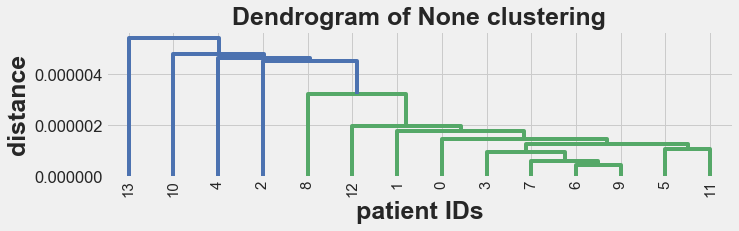

In [37]:
df = combined_data
data_scaled = normalize(df.drop(['timepoint', 'patient id'], axis=1))
df = pd.DataFrame(data_scaled, columns=df.drop(['timepoint', 'patient id'], axis=1).columns)

df[['patient id', 'timepoint']] = combined_data[['patient id', 'timepoint']]
target=['telo means', '# inversions', '# terminal inversions', '# dicentrics']
cut_off_n=4
df = df.copy()

# preparing data
df['timepoint'] = df['timepoint'].apply(lambda row: trp.encode_timepts(row))
df = df[['patient id', 'timepoint'] + target].copy()
df = df.pivot(index='patient id', values=target, columns='timepoint').reset_index()
df.set_index('patient id', inplace=True)

# run the clustering    
cluster_Z = hac.linkage(df, method='single', metric=trp.myMetric)
trp.plot_dendogram(cluster_Z)

# concat clusters to original df and return
ready_concat = df.reset_index()
result = pd.Series(hac.fcluster(cluster_Z, 3, criterion='maxclust'))
all_data_cluster = pd.concat([result, ready_concat], axis=1)

In [38]:
all_data_cluster.rename(columns={('patient id', ''): 'patient id',
                                  0: 'all data cluster group'}, inplace=True)

parsed = all_data_cluster[['patient id', 'all data cluster group']].copy()
all_data_clustered = combined_data.merge(parsed, on='patient id')
all_data_clustered.head()

,patient id,timepoint,telo means,# inversions,# terminal inversions,# sister chromatid exchanges,# dicentrics,excess chr fragments,# sat associations,# terminal SCEs,# translocations,all data cluster group
0,1,1 non irrad,84.796483,0.066667,0.166667,0.633333,0.000000,0.000000,0.133333,0.566667,0.033333,1
1,1,2 irrad @ 4 Gy,90.975826,0.466667,0.300000,0.800000,0.400000,0.366667,0.033333,0.666667,0.133333,1
2,1,3 B,116.779989,0.800000,0.466667,0.700000,0.366667,0.433333,0.766667,0.800000,0.100000,1
3,1,4 C,99.346299,0.300000,0.266667,0.933333,0.066667,0.266667,0.366667,0.766667,0.133333,1
4,2,1 non irrad,119.773675,0.200000,0.100000,0.533333,0.000000,0.033333,0.333333,0.766667,0.033333,1


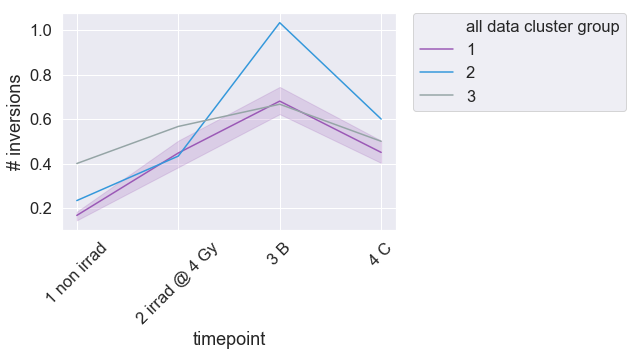

In [40]:
trp.graph_cluster_groups(all_data_clustered, target='# inversions', hue='all data cluster group')

In [ ]:
trp.graph_clusters_per_patient(all_data_clustered, target='telo means', cluster_name='all data cluster group',
                               y_dimen=1, x_dimen=3, fsize=(12,4))